# Unsupervised Machine Learning Final


For my final project I wanted to learn more about how Google's search algorithm makes decisions when ranking websites. While the algorithm and all of the parameters that go into these rankings is not publicly available, it's known that certain factors like readable text on a page, locations linked to pages, alt text on graphics, external links, and backlinks play a major role in getting a website ranked favorably. I want to specifically explore how the readable text on a page can factor into how a website ranks. For this project, I am defining readable text as any text that can be found in H1-H6 tags and in p tags. 

The cell below contains all of the libraries that were used for this project

In [35]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from urllib.parse import urljoin
import plotly.express as px
import plotly.express as px
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/adriannaqueen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/adriannaqueen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Step 1: Gather Data
The first step I took for this project was colleecting the necessary data. I followed basic webscraping code that used BeautifulSoup to extract the H tags and the P tags for 10 websites in the landscaping business. Since I want to respect the privacy of the sites that I scraped, I performed the actual websraping in another notebook and assigned non-identifying unique IDs to the sites and their domains. I kept the url structure for the internal page the same to be able to differentiate between pages. For example, if the webpage was origianally www.example.com/service_page, I changed it to ls_1/service_page. I included the code in the following cell that I used to collect the data. The only change is putting in the actual base webpage in base_url instead of "https://www.example.com".

The only other preprocessing steps I took that are not shown in this notebook were removing duplicate entries (some of the sites included forms that generated unique urls but had duplicate h_text and p_text) and removing any rows that featured urls that did not come from the base website (the links to the companies' social media sites were included in the get_internal_links function, and I felt that including that was out of scope for this project).

In [ ]:
def get_page_content(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    return None

def extract_text_from_tags(html_content):
    soup = BeautifulSoup(html_content, 'html.parser')
    
    # Extract text from <p> tags
    p_tags = soup.find_all('p')
    p_text = ' '.join([p.get_text() for p in p_tags])
    
    # Extract text from all header tags <h1>, <h2>, etc.
    h_tags = soup.find_all(['h{}'.format(i) for i in range(1, 7)])
    h_text = ' '.join([h.get_text() for h in h_tags])
    
    return p_text, h_text

def scrape_page(url):
    html_content = get_page_content(url)
    if html_content:
        p_text, h_text = extract_text_from_tags(html_content)
        return {'url': url, 'p_text': p_text, 'h_text': h_text}
    return None

def scrape_website(base_url, pages):
    urls = [f"{base_url}/{page}" for page in pages]
    
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(scrape_page, urls))
    
    # Filter out None values (failed requests)
    results = [result for result in results if result is not None]
    
    # Create DataFrame from the results
    df = pd.DataFrame(results)
    
    return df



def get_internal_links(base_url):
    response = requests.get(base_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')
        internal_links = [urljoin(base_url, a['href']) for a in soup.find_all('a', href=True)]
        return internal_links
    return []

def crawl_website(base_url, max_depth=3):
    visited_urls = set()
    urls_to_visit = [(base_url, 0)]

    while urls_to_visit:
        current_url, depth = urls_to_visit.pop(0)

        if current_url not in visited_urls and depth <= max_depth:
            visited_urls.add(current_url)

            # Scrape the page here (using your scrape_page function)
            print(f"Scraping {current_url}")

            # Get internal links from the current page
            internal_links = get_internal_links(current_url)
            urls_to_visit.extend((link, depth + 1) for link in internal_links)

    return visited_urls

if __name__ == "__main__":
    
    base_url = "https://www.example.com"
    
    # Crawl the website and get a set of all visited URLs
    all_visited_urls = crawl_website(base_url)

    # List to store scraped data
    scraped_data = []

    # Now, you can use the list of visited URLs to scrape the content of each page
    for url in all_visited_urls:
        print(f"Scraping {url}")
        
        # Call your scraping functions here and append the results to the list
        scraped_data.append(scrape_page(url))

    # Create a DataFrame from the list of scraped data
    df = pd.DataFrame(scraped_data)


Now I will actually read in the data

In [26]:
# initialize empty dataframe
df = pd.DataFrame()

# read in each csv file and concatenate together into one dataframe
for i in range(1,11):

    tmp = pd.read_csv("data_for_final/ls_{}.csv".format(i))
    df = pd.concat([df,tmp])

# remove extra index column
df = df.drop(columns=['Unnamed: 0'])

# View head
df.head()

,url,p_text,h_text,company_id,google_rank
0,ls_1/services/landscape-design-build/,"NOW DESIGNING CHARLOTTE At DalaCasa, we bring ...",Landscape Design & Build PROJECTS AT EVERY SCA...,ls_1,1
1,ls_1/services/winter-pruning/,Services / Yard Maintenance / Winter Pruning A...,Winter Pruning Pruning to Your Potential Dala ...,ls_1,1
2,ls_1/project-portfolio/,We take pride in our work and are confident in...,DalaCasa Project Portfolio Locations Follow us...,ls_1,1
3,ls_1/services/mulch-pine-needles/,Services / Yard Maintenance / Mulch & Pine Nee...,Mulch & Pine Needles Looks Good. Does Good. Mu...,ls_1,1
4,ls_1/services/shrub-trimming/,Services / Yard Maintenance / Shrub Trimming I...,Shrub Trimming Details Make a Difference Two S...,ls_1,1


In [11]:
# inspect the shape and summary statistics of df
print("The shape of the dataframe is: ",df.shape)
df.describe()

The shape of the dataframe is:  (294, 5)


,google_rank
count,294.000000
mean,3.925170
std,2.320964
min,1.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,10.000000


## Step 2: Identify Unsupervised Machine Learning Problem

1. Non Negative Matrix Factorization
- Effective at looking at finding term importance on a page 
- Good for independent topic analysis

2. Topic Modeling and Sentiment Analysis
- Extract insights on specific websites and pages
- See how topics compared across the local industry
- Explore how google ranks sentiment


## Step 3: Exploratory Data Analysis

The data comes from the top 10 ranking landscaping websites in the area I pulled from. Each was collected into it's own .csv and concatenated together into one dataframe. The structure of the dataframe is:
- url: the adjusted url of the webpage (see step 1 for explanation on how this was generated)
- p_text: all of the text on the page that was contained in an html p tag
- h_text: all of the text on the page that was contained in an html h tag (1-6 is treated the same)
- company_id: non-identifying unique ID for each of the 10 websites that I scraped
- google_rank: the rank of the website on google at the time of being scraped

The main visualizations I will generate will help illustrate how many pages each company has, which words are commonly seen across all of the sites, and which words are unique to certain sites.

Since I am working with mainly text data, I will not need to do any sort of numeric normalization nor any sort of log transform. I will, however, need to preprocess the data so that the model is able to better read the data and understand which text can be clustered together. 

First I will need to preprocess the text data. I will follow the common text preprocessing steps of:
1. remove punctuation
2. convert text to all lowercase
3. tokenize the text
4. remove stopwords from thhe text

In [164]:
def preprocess_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Join the words back into a string
    preprocessed_text = ' '.join(words)
    
    return preprocessed_text

df['p_text'] = df['p_text'].apply(preprocess_text)
df['h_text'] = df['h_text'].apply(preprocess_text)

The above error means that some of the data in my h_text column is not a string. This should not be the case as it is expected that all of the data in the p_text and h_text columns are in the string format. Let's investigate this further.

In [16]:
non_string_rows = df[df['h_text'].apply(lambda x: not isinstance(x, str))]

non_string_rows

,url,p_text,h_text,company_id,google_rank
8,ls_1/wp-content/uploads/2023/02/dalacasa-lands...,lt c ox e fy sd os hd eu k f g u u vk ndd fe u...,NaN,ls_1,1
15,ls_1/wp-content/uploads/2023/02/image_6483441_...,nfkcl bo u z u ga l r p j ql p w u j z rl l qj,NaN,ls_1,1
16,ls_1/wp-content/uploads/2023/02/Aeration-2-1.jpg,jr b e w j jaoc w kt zs x r z nrg f,NaN,ls_1,1
0,ls_9wp-content/uploads/2023/09/j.h.s-outdoor-l...,v f b k l du r v w aieh xz xn u n e r wl,NaN,ls_9,9
2,ls_9wp-content/uploads/2023/09/j.h.s-outdoor-l...,c x f e atk pn g wnf f ltr,NaN,ls_9,9
3,ls_9wp-content/uploads/2023/09/j.h.s-outdoor-l...,g mg c fu rk kw yro b bnjxd j r u u x e b w u ...,NaN,ls_9,9
5,ls_9wp-content/uploads/2023/09/j.h.s-outdoor-l...,p e h ug g rz g b p nwe id n r u k h yv z g hy...,NaN,ls_9,9
6,ls_9wp-content/uploads/2023/10/jhs-outdoor-liv...,w,NaN,ls_9,9
10,ls_9wp-content/uploads/2023/10/jhs-outdoor-liv...,w k w pasl r bx x x j x ox f c zq k qh f rbc q...,NaN,ls_9,9
12,ls_9wp-content/uploads/2023/09/j.h.s-outdoor-l...,x dz f c g g q h fc cx f w f f,NaN,ls_9,9


It looks like some of the image links got missed while preprocessing the data externally. I'll get rid of those rows since they do not add anything to the analysis.

In [27]:
df = df[df['h_text'].apply(lambda x: isinstance(x, str))]
df.reset_index(drop=True, inplace=True)
df = df[df['p_text'].apply(lambda x: isinstance(x, str))]
df.reset_index(drop=True, inplace=True)

df['p_text'] = df['p_text'].apply(preprocess_text)
df['h_text'] = df['h_text'].apply(preprocess_text)

In [28]:
df

,url,p_text,h_text,company_id,google_rank
0,ls_1/services/landscape-design-build/,designing charlotte dalacasa bring landscaping...,landscape design build projects every scale fo...,ls_1,1
1,ls_1/services/winter-pruning/,services yard maintenance winter pruning imagi...,winter pruning pruning potential dala casa off...,ls_1,1
2,ls_1/project-portfolio/,take pride work confident satisfaction dalacas...,dalacasa project portfolio locations follow us...,ls_1,1
3,ls_1/services/mulch-pine-needles/,services yard maintenance mulch pine needles a...,mulch pine needles looks good good mulch types...,ls_1,1
4,ls_1/services/shrub-trimming/,services yard maintenance shrub trimming manic...,shrub trimming details make difference two ser...,ls_1,1
...,...,...,...,...,...
276,ls_9services,believe power transformation convert exterior ...,services retaining walls land grading outdoor ...,ls_9,9
277,ls_9about/,began j h outdoor living four years ago humble...,meet team transforming outdoors luxurious livi...,ls_9,9
278,ls_10groups,home book online grupos miembros brothers land...,groups,ls_10,10
279,ls_10,home book online grupos miembros exceptional s...,brothers landscape maintenance us professional...,ls_10,10


Now I am going to get started on visualizing my data

In [31]:
# Visualization 1: Number of Pages per Company
pages_per_company = df.groupby('company_id')['url'].count().reset_index()

fig1 = px.bar(pages_per_company, x='company_id', y='url', title='Number of Pages per Company')
fig1.show()

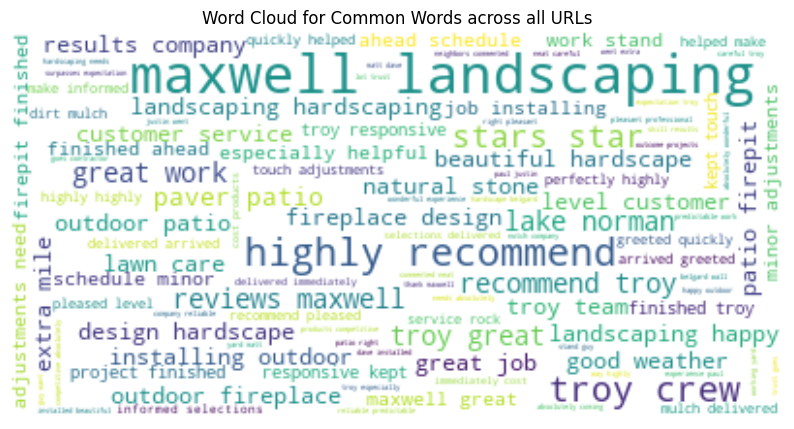

In [32]:
# Visualization 2: Word Cloud for Common Words across all URLs
all_text = ' '.join(df['p_text'] + ' ' + df['h_text'])
wordcloud_all = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Common Words across all URLs")
plt.show()

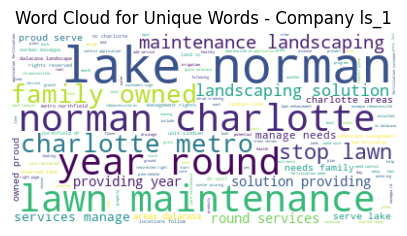

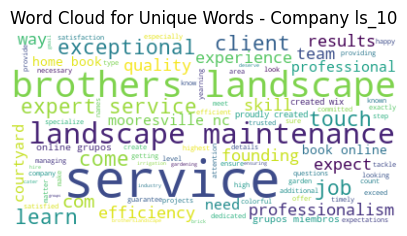

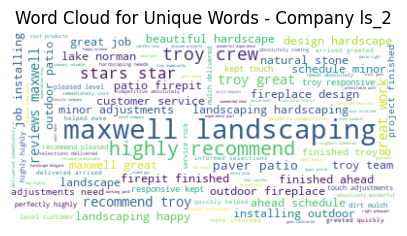

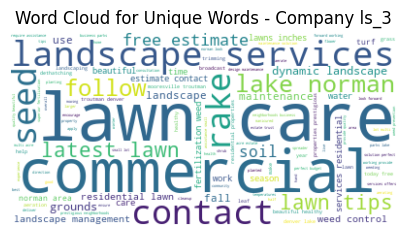

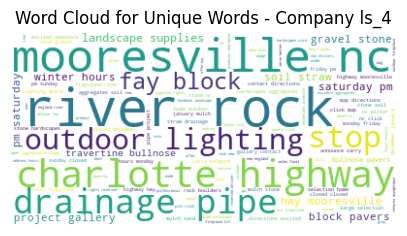

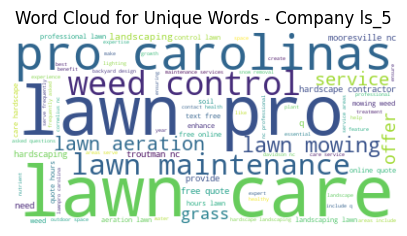

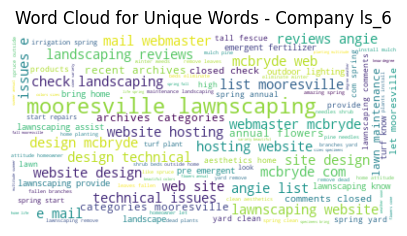

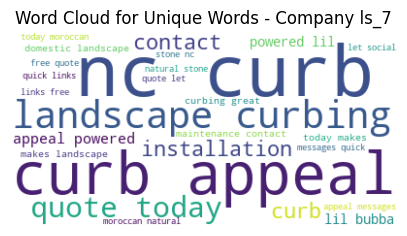

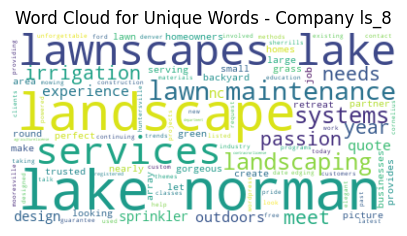

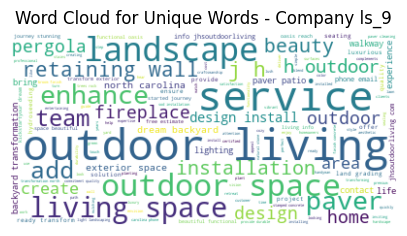

In [34]:
# Visualization 3: Word Clouds for Unique Words per Company
for company_id, group in df.groupby('company_id'):
    company_text = ' '.join(group['p_text'] + ' ' + group['h_text'])
    wordcloud_company = WordCloud(stopwords=ENGLISH_STOP_WORDS, background_color='white').generate(company_text)

    plt.figure(figsize=(5, 3))
    plt.imshow(wordcloud_company, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Unique Words - Company {company_id}")
    plt.show()

## Step 4: Perform Analysis using FILL IN MODEL 
I will now begin developing my model. I will also be sure to include hyperparameter tuning

In [36]:
# Use matrix factorization to test the p_text data

# Step 1: Create a document-term matrix using TF-IDF
p_vectorizer = TfidfVectorizer(stop_words='english')
p_tfidf_matrix_train = p_vectorizer.fit_transform(df['p_text'])

# Step 2: Apply NMF to the TF-IDF matrix
num_topics = 10  
p_nmf_model = NMF(n_components=num_topics, random_state=42)
p_nmf_matrix_train = p_nmf_model.fit_transform(p_tfidf_matrix_train)

# Step 3: Predict the labels for the p_text dataset
p_text_labels = p_nmf_matrix_train.argmax(axis=1)

# Step 4: Create a pipeline for future use
p_model_pipeline = make_pipeline(p_vectorizer, p_nmf_model)

In [37]:
# Use matrix factorization to test the h_text data

# Step 1: Create a document-term matrix using TF-IDF
h_vectorizer = TfidfVectorizer(stop_words='english')
h_tfidf_matrix_train = h_vectorizer.fit_transform(df['h_text'])

# Step 2: Apply NMF to the TF-IDF matrix
h_nmf_model = NMF(n_components=num_topics, random_state=42)
h_nmf_matrix_train = h_nmf_model.fit_transform(h_tfidf_matrix_train)

# Step 3: Predict the labels for the p_text dataset
h_text_labels = h_nmf_matrix_train.argmax(axis=1)

# Step 4: Create a pipeline for future use
h_model_pipeline = make_pipeline(h_vectorizer, h_nmf_model)

In [39]:
# Get the feature names (words) from the vectorizer
p_feature_names = p_vectorizer.get_feature_names_out()
h_feature_names = h_vectorizer.get_feature_names_out()

# Get the top words for each p_text topic from the NMF model
p_top_words_per_topic = {}
for topic_idx, topic in enumerate(p_nmf_model.components_):
    top_words_idx = topic.argsort()[:-10-1:-1]  # Selecting top 10 words for each topic
    top_words = [p_feature_names[i] for i in top_words_idx]
    p_top_words_per_topic[f'Topic {topic_idx + 1}'] = top_words

# Get the top words for each p_text topic from the NMF model
h_top_words_per_topic = {}
for topic_idx, topic in enumerate(h_nmf_model.components_):
    top_words_idx = topic.argsort()[:-10-1:-1]  # Selecting top 10 words for each topic
    top_words = [h_feature_names[i] for i in top_words_idx]
    h_top_words_per_topic[f'Topic {topic_idx + 1}'] = top_words

# Print the top words for each topic
print("Top topics for the Paragraph text data")
for topic, top_words in p_top_words_per_topic.items():
    print(f"{topic}: {', '.join(top_words)}")

print("----"*30)
print("Top topics for the Heading text data")
for topic, top_words in h_top_words_per_topic.items():
    print(f"{topic}: {', '.join(top_words)}")

Top topics for the Paragraph text data
Topic 1: troy, maxwell, crew, job, landscaping, recommend, highly, great, work, went
Topic 2: lawnscaping, website, mcbryde, mooresville, mail, design, technical, webmaster, angie, web
Topic 3: lawn, carolinas, pro, services, weed, mowing, aeration, grass, control, troutman
Topic 4: dalacasa, charlotte, metro, northfield, iindian, sc, unit, owned, mazeppa, land
Topic 5: directions, aggregates, pipe, highway, stone, closed, charlotte, drainage, soil, straw
Topic 6: curb, lil, bubba, powered, appeal, nc, pine, home, needles, fence
Topic 7: annual, flowers, spring, lawnscaping, remove, mcbryde, home, website, spruce, specimens
Topic 8: outdoor, living, space, exterior, lighting, backyard, design, landscape, journey, spaces
Topic 9: landscape, grounds, business, prestigious, neighborhoods, dynamic, season, parks, properties, commercial
Topic 10: fescue, tall, arriving, stressed, operating, degree, irrigation, prior, efficiently, hot
------------------

In [45]:
# Get the indices of the top documents for each topic
top_documents_per_topic = {}
for topic_idx in range(num_topics):
    top_documents_idx = p_nmf_matrix_train[:, topic_idx].argsort()[:-1-1:-1]  # Selecting first documents for each topic
    top_documents = df.loc[top_documents_idx, 'p_text'].tolist()
    top_documents_per_topic[f'Topic {topic_idx + 1}'] = top_documents

# Print or inspect the top documents for each topic
for topic, top_documents in top_documents_per_topic.items():
    print(f"{topic}:")
    for idx, document in enumerate(top_documents, start=1):
        print(f"Document {idx}: {document}")
    print("=" * 50)


Topic 1:
Document 1: based reviews maxwell great job installing outdoor patio firepit finished ahead schedule minor adjustments need made project finished troy responsive kept touch adjustments made perfectly highly highly recommend pleased level customer service rock fill dirt mulch delivered arrived greeted quickly helped make informed selections delivered immediately cost products competitive absolutely coming back landscaping hardscaping needs absolutely wonderful experience paul justin went extra mile get paver patio right pleasant professional several neighbors commented neat careful troy especially helpful every way highly recommend top notch company reliable predictable work would put skill results company anyone outcome projects always surpasses expectation troy great work stand guy want anyone else working yard matt dave installed beautiful hardscape belgard wall front yard would highly recommend troy crew everyone thank maxwell landscaping happy outdoor fireplace design hard

In [47]:
df[df.p_text.str.contains("based reviews maxwell great job installing outdoor patio firepit finished ahead schedule minor adjustments need made project finished troy responsive kept")]['company_id'].unique()

array(['ls_2'], dtype=object)

In [64]:
print(list(top_documents_per_topic.values())[1][0])
print(list(top_documents_per_topic.values())[6][0])
print(list(top_documents_per_topic.values())[9][0])

comments closed check landscaping reviews angie list mooresville lawnscaping website hosting website design mcbryde web site design technical issues e mail webmaster mcbryde com
know degree weather soon upon us important irrigation system operating efficiently prior hot weather arriving ensure tall fescue turf plants stressed due high would like spruce outside home planting multitude summer annual flowers annual flowers come variety beautiful colors sizes specimens bring home life spring fall mooresville lawnscaping amazing spring clean aesthetics home attitude homeowner let mooresville lawnscaping remove leaves fallen branches yard remove dead plants install mulch pine needles shrub beds eliminate winter weeds put nice check landscaping reviews angie list mooresville lawnscaping website hosting website design mcbryde web site design technical issues e mail webmaster mcbryde com
know degree weather soon upon us important irrigation system operating efficiently prior hot weather arrivin

In [61]:
for i in range(len(list(top_documents_per_topic.values()))):
    s = df[df.p_text.str.contains(list(top_documents_per_topic.values())[i][0])]['company_id'].unique()
    print(s)

['ls_2']
['ls_6']
['ls_5']
['ls_1']
['ls_4']
['ls_7']
['ls_6']
['ls_9']
['ls_3']
['ls_6']


In [114]:
documents_per_topic = {}

for topic_idx in range(num_topics):
    # Find the indices of documents for the current topic, sorted by relevance
    topic_documents_idx = p_nmf_matrix_train[:, topic_idx].argsort()#[:-10-1:-1]
    
    # Extract all documents for the current topic
    topic_documents = df.loc[topic_documents_idx, 'p_text'].tolist()
    
    # Store the list of documents for the current topic
    documents_per_topic[f'Topic {topic_idx + 1}'] = topic_documents

c_id = {}
for i in range(10):
    c_ls = []
    print("starting topic {}".format(i))
    for j in range(len(list(documents_per_topic.values())[i])):
        # print(i,': ',len(list(documents_per_topic.values())[i][j]))
        c_ls.append(df[df.p_text.str.contains(list(documents_per_topic.values())[i][j])]['company_id'].unique())
    c_id[i] = c_ls


starting topic 0
2
starting topic 1
2
starting topic 2
2
starting topic 3
2
starting topic 4
2
starting topic 5
2
starting topic 6
2
starting topic 7
2
starting topic 8
2
starting topic 9
2


In [160]:
p_results = pd.DataFrame(c_id)
filtered_df = p_results[p_results.apply(lambda row: all(len(lst) <= 1 for lst in row), axis=1)]

filtered_df.head()

,0,1,2,3,4,5,6,7,8,9
0,[ls_3],[ls_3],[ls_1],[ls_3],[ls_6],[ls_1],[ls_3],[ls_3],[ls_7],[ls_7]
1,[ls_5],[ls_3],[ls_2],[ls_6],[ls_2],[ls_5],[ls_3],[ls_3],[ls_6],[ls_3]
2,[ls_5],[ls_3],[ls_2],[ls_3],[ls_2],[ls_5],[ls_3],[ls_3],[ls_2],[ls_6]
3,[ls_5],[ls_3],[ls_2],[ls_3],[ls_2],[ls_5],[ls_3],[ls_3],[ls_2],[ls_6]
4,[ls_5],[ls_9],[ls_2],[ls_6],[ls_6],[ls_5],[ls_4],[ls_3],[ls_6],[ls_3]


In [158]:
i=1
df_results = pd.DataFrame({'google_rank':[],'predicted_count':[]})

for column in filtered_df.columns:

    value_counts = filtered_df[column].apply(tuple).value_counts()
    # print(column+1, ': ', value_counts[tuple(['ls_{}'.format(i)])])
    df_results.loc[len(df_results.index)] = [column+1,value_counts[tuple(['ls_{}'.format(i)])]]
    i+=1


# df_results

In [163]:
t = df['google_rank'].value_counts().sort_values().reset_index()
t = df_results.merge(t,on='google_rank')
# t['accuracy'] = t['predicted_count'] / t['count']
# tp = pred count
# tn = 281 - count
t['accuracy_score'] = (t['predicted_count'] + (281 - t['count'])) / 281
t[['google_rank','accuracy_score']]

,google_rank,accuracy_score
0,1,0.992883
1,2,0.992883
2,3,0.996441
3,4,0.996441
4,5,0.985765
5,6,0.985765
6,7,1.000000
7,8,1.000000
8,9,1.000000
9,10,1.000000


Surprisingly, the accuracy got better with the websites that did not have as many webpages on their sites.

In [68]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans  # Assuming you use KMeans, replace with your clustering algorithm

num_clusters = 10  
clusterer = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = clusterer.fit_predict(p_nmf_matrix_train)

# Calculate the silhouette score
silhouette_avg = silhouette_score(p_nmf_matrix_train, cluster_labels)

# Print the silhouette score
print(f"Silhouette Score: {silhouette_avg}")


/Users/adriannaqueen/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score: 0.7046108223855531


/Users/adriannaqueen/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



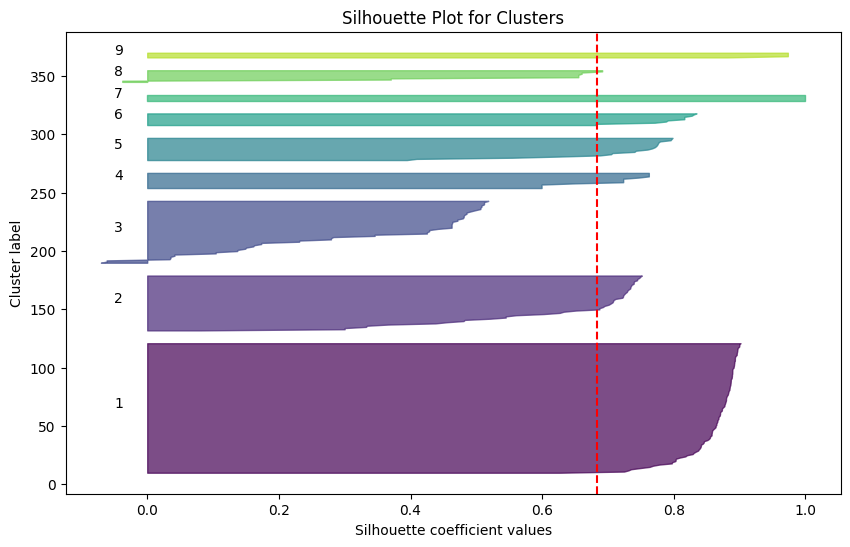

In [74]:
from sklearn.metrics import silhouette_samples

cluster_labels = clusterer.fit_predict(p_nmf_matrix_train)

# Calculate silhouette scores for each data point
silhouette_vals = silhouette_samples(p_nmf_matrix_train, cluster_labels)

# Create a silhouette plot
plt.figure(figsize=(10, 6))

y_lower = 10
for i in range(num_clusters):
    # Aggregate the silhouette scores for samples belonging to cluster i and sort them
    ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    ith_cluster_silhouette_vals.sort()

    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.viridis(float(i) / num_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_vals,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i + 1))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

# Labeling and styling
plt.title("Silhouette Plot for Clusters")
plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
average_score = silhouette_vals.mean()
plt.axvline(x=average_score, color="red", linestyle="--", label='Average Silhouette Score')

plt.show()


It looks like clusters 1, 2, 4, 5, 6, 7, and 9 performed well in terms of silhouette score, with cluster 3 and 8 performing adequately. While 3 and 8 are between 0.4 and 0.6, positive scores represent better similarity.

#### Performing Hyperparameter tuning using cross validation

### Discussion and Conclusion from results
From completing this project, I found that the higher ranking websites were actually more difficult to extract useful information from. I believe this is due to a higher volume of pages across the website having a variety of topics.  This makes sense from an SEO standpoint since each web page would target a specific keyword (if done properly), so each page would vary quite a bit from one to the other. 

I also found that the sentiment scores across the websites were overall positive, but the degree of positive sentiment did not seem to be a major factor in google's ranking algorithm.